NLP Project

Load Packages

In [265]:
import os
import sys
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

#pre-processing of text
import string
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import pandas as pd #to work with csv files
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.svm import OneClassSVM

In [ ]:
# Overall goal is to handle imbalanced data.

Clean Twitter data

In [266]:
def clean_text(str_list, lemmatize=True):
    clean_list = []

    for text in str_list:
        # Remove pound sign from hashtags
        text = re.sub(r'#', '', text)
        # Remove URLs
        text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]*", '', text)

        words = word_tokenize(text)
        clean_words = []

        lemmatizer = WordNetLemmatizer()  # Move lemmatizer initialization outside the loop
        
        for word in words:
            # Drop words with fewer than 2 characters and drop any punctuation "words", this will also get rid of the emojis
            if len(word) > 1 and re.match(r'^\w+$', word):
                if lemmatize:
                    word = lemmatizer.lemmatize(word)  # Apply lemmatization
                clean_words.append(word)
        
        clean_text = ' '.join(clean_words)
        clean_list.append(clean_text)
    
    return clean_list

In [267]:
test_tweets = pd.read_csv('COVID19_Dataset-text_labels_only.csv')


#Filter tweets for train data (false)
false_tweets = pd.read_csv('fakeNews.csv')
# Filter rows where the 'Origin' column is equal to 'Twitter'
false_tweets.query("Origin == 'Twitter'")

# Display the head of the datasets
print("COVID-19 Dataset:")
print(test_tweets.head())
print("\nFake News Dataset (Twitter Origin):")
print(false_tweets.head())



#Clean data 
test_tweets['clean tweet'] = clean_text(test_tweets['Tweet'])
false_tweets['clean text'] = clean_text(false_tweets['Text'])

#View Data set
test_tweets.head()
print(false_tweets)


COVID-19 Dataset:
   Is_Unreliable    Category  \
0              1  1, 3, 6, 9   
1              1  1, 6, 8, 9   
2              1     1, 4, 9   
3              1        6, 8   
4              1     6, 8, 9   

                                               Tweet  
0  We are living in scary times in Canada. Gov’t ...  
1  Just as bad in Canada. In fact, our government...  
2  It was only a matter of time before the mainst...  
3  Russia's taking no chances: Foreigners infecte...  
4  Although there is now a presumptive confirmed ...  

Fake News Dataset (Twitter Origin):
  Date Posted                                               Link  \
0      2/7/20  https://www.poynter.org/?ifcn_misinformation=t...   
1      2/7/20  https://www.poynter.org/?ifcn_misinformation=t...   
2      2/7/20  https://www.poynter.org/?ifcn_misinformation=t...   
3      2/7/20  https://www.poynter.org/?ifcn_misinformation=t...   
4      2/7/20  https://www.poynter.org/?ifcn_misinformation=c...   

             

Data Distribution

reference for visualization: https://zablo.net/blog/post/twitter-sentiment-analysis-python-scikit-word2vec-nltk-xgboost/index.html

In [268]:
import plotly
from plotly import graph_objs

In [269]:
false = len(false_tweets[false_tweets['Binary Label']== 0])
dist = [
    graph_objs.Bar(
        x=["false tweets"],
        y=[false],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Amount of False Tweets in Training Set")})

The false and true are about equal so need to make false a minority class

In [270]:
df = test_tweets
false = len(df[df["Is_Unreliable"] == 1])
true = len(df[df["Is_Unreliable"] == 0])
dist = [
    graph_objs.Bar(
        x=["false", "true"],
        y=[false, true],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Sentiment type distribution in training set")})

Creating imbalance class scenario

In [271]:
def create_imbalance(df, removal_count=250):
    # Shuffle the DataFrame to ensure randomness
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Get the count of tweets labeled as false
    false_count = len(df_shuffled[df_shuffled['Is_Unreliable'] == 1])
    
    # Determine the number of false tweets to remove
    remove_false_count = min(removal_count, false_count)
    
    # Remove false tweets
    removed_count = 0
    indexes_to_remove = []
    for index, row in df_shuffled.iterrows():
        if row['Is_Unreliable'] == 1:
            indexes_to_remove.append(index)
            removed_count += 1
            if removed_count >= remove_false_count:
                break
    
    df_balanced = df_shuffled.drop(indexes_to_remove)
    
    return df_balanced


In [272]:
less_false_test_data = create_imbalance(test_tweets, removal_count=200)

In [273]:
df = less_false_test_data
false = len(df[df["Is_Unreliable"] == 1])
true = len(df[df["Is_Unreliable"] == 0])
dist = [
    graph_objs.Bar(
        x=["false", "true"],
        y=[false, true],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Sentiment type distribution in training set")})

Intentially making false tweets the minority class. Reference: https://r.search.yahoo.com/_ylt=AwrijsYZKApm0HsPR1oPxQt.;_ylu=Y29sbwNiZjEEcG9zAzEEdnRpZAMEc2VjA3Ny/RV=2/RE=1711970458/RO=10/RU=https%3a%2f%2ftowardsdatascience.com%2fclass-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a/RK=2/RS=GZO8i_5pEucAFqi1p1qRh7Vqn0o-

In [274]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

In [275]:
#create imbalance dataset
X= less_false_test_data['clean tweet']
y= less_false_test_data['Is_Unreliable']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


#Check the number of records

print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])

The number of records in the training dataset is 288
The number of records in the test dataset is 72


Feature Engineering

Instead of tfidf, we are going to use the Glove feature extraction instead. The accuracy was pretty low when using this feature extraction and it could be based on the sophistication: ability to capture semantic meaning and contextual relationships. Additionally, we get to use a large dataset to derive 

## Word2Vec

In [276]:
from gensim.models import Word2Vec, KeyedVectors
# Load vectors directly from the file
import gensim
import numpy as np

# Load pre-trained Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [277]:
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0
        for token in tokens:
            if token in word2vec_model:
                feat_for_this += word2vec_model[token]
                count_for_this +=1
        feats.append(feat_for_this/count_for_this)        
    return feats

In [278]:
train_feats = embedding_feats(X_train)
test_feats = embedding_feats(X_test)

In [279]:
# Convert to dense matrices
dense_train_X = np.array(train_feats)
dense_test_X = np.array(test_feats)

In [280]:
print("Train feature shape:", dense_train_X.shape)
print("Test feature shape:", dense_test_X.shape)

Train feature shape: (288, 300)
Test feature shape: (72, 300)


## Train One-Class Support Vector Machine (SVM) Model

In [281]:
#code referenced: https://youtu.be/0IkFnHpUUjE?si=tHuVHJj_KJhzn-a9

In [282]:
one_class_svm = OneClassSVM(nu=.01, kernel = 'rbf', gamma ='auto').fit(dense_train_X[y_train == 0]) #Fit only on normal instances
# nu means it allows 1% of outliers in the dataset
# maps data from a low demensional space to a high dimensional space
#gamma is a decision boundary

### Predictions + Evaluation

In [283]:
prediction = one_class_svm.predict(dense_test_X)

#Change the anomalies' valyes to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction] #Changed from -1 to 1 and 1 to 0 for binary classification

#Performance
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85        54
           1       0.00      0.00      0.00        18

    accuracy                           0.74        72
   macro avg       0.37      0.49      0.42        72
weighted avg       0.56      0.74      0.64        72



## Hyperparameters: Customize Predictions Using Scores
instead of using the default threshold for identifying outliers, we can customize the threshold and label more or fewer data points as outliers. For example, in the code below, we find the score for 2% of the data points and use it as the prediction threshold.

In [284]:
#Get the scores for the testing dataset
score = one_class_svm.score_samples(dense_test_X)


#Check the score for 2% of outliers
score_threshold = np.percentile(score,2)
print(f'The customized score threshold for 2% of outliers is {score_threshold: .2f}')

The customized score threshold for 2% of outliers is  2.25


In [285]:
#Check the model performance at 2% threshold 
customized_prediction = [1 if i < score_threshold else 0 for i in score]


#Check the prediction performance
print(classification_report(y_test, customized_prediction))

              precision    recall  f1-score   support

           0       0.74      0.96      0.84        54
           1       0.00      0.00      0.00        18

    accuracy                           0.72        72
   macro avg       0.37      0.48      0.42        72
weighted avg       0.56      0.72      0.63        72



## Solely Train False Tweets
The 1 label or false tweets are not being recognize using this method. Less try to train solely the minority class in the training set.

In [430]:
#Now using solely false tweets
train_x = false_tweets

#Convert to Word2Vec
embed_x = embedding_feats(train_x)

#Dense
dense_X = np.array(embed_x)

trainy = false_tweets['Binary Label']

In [431]:
test_X = less_false_test_data['clean tweet']
test_y = less_false_test_data['Is_Unreliable']

#Convert to Word2Vec
embed_test = embedding_feats(test_X)

#Dense
dense_test_X = np.array(embed_test)



In [432]:
one_class_svm = OneClassSVM(nu=.01, kernel = 'rbf', gamma ='auto').fit(dense_X) #Fit only on normal instances
# nu means it allows 1% of outliers in the dataset ( we know the training data is 17% of the testing)
# maps data from a low demensional space to a high dimensional space
#gamma is a decision boundary

## Prediction by default

In [433]:
prediction = one_class_svm.predict(dense_test_X)

#Change the anomalies' valyes to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction] #Changed from -1 to 1 and 1 to 0 for binary classification

#Performance
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       280
           1       0.22      1.00      0.36        80

    accuracy                           0.22       360
   macro avg       0.11      0.50      0.18       360
weighted avg       0.05      0.22      0.08       360



c:\Users\rchlr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\rchlr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\rchlr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [434]:
#Get the scores for the testing dataset
score = one_class_svm.score_samples(dense_test_X)


#Check the score for 2% of outliers
score_threshold = np.percentile(score,2)
print(f'The customized score threshold for 2% of outliers is {score_threshold: .2f}')

The customized score threshold for 2% of outliers is  0.12


# Get a better accuracy with score_threshold

In [435]:
#Check the model performance at 2% threshold 
customized_prediction = [1 if i < score_threshold else 0 for i in score]


#Check the prediction performance
print(classification_report(test_y, customized_prediction))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87       280
           1       0.38      0.04      0.07        80

    accuracy                           0.77       360
   macro avg       0.58      0.51      0.47       360
weighted avg       0.69      0.77      0.69       360



Code referenced: https://youtu.be/O9VvmWj-JAk?si=t2xTI7RQGdDzuIAr

In [436]:
X = dense_test_X

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [441]:
df = pd.DataFrame({
    'Feature 1': X_pca[:, 0],  # Assuming you want to use the first feature of dense_test_X
    'Feature 2': X_pca[:, 1],  # Assuming you want to use the second feature of dense_test_X
    'Binary Label': test_y,
    'one_class_svm_prediction': prediction,
    'one_class_svm_prediction_customized': customized_prediction
})

# Display the DataFrame
print(df)

     Feature 1  Feature 2  Binary Label  one_class_svm_prediction  \
0    -0.099211  -0.115684             0                         1   
1    -0.124911  -0.145686             0                         1   
4    -0.013666  -0.074679             0                         1   
7    -0.091699  -0.049356             0                         1   
9    -0.104272  -0.047136             0                         1   
..         ...        ...           ...                       ...   
555  -0.163785   0.009048             1                         1   
556  -0.146150  -0.042382             1                         1   
557  -0.034038  -0.037911             1                         1   
558  -0.048264   0.059364             0                         1   
559  -0.136209   0.097845             1                         1   

     one_class_svm_prediction_customized  
0                                      0  
1                                      0  
4                                      0  

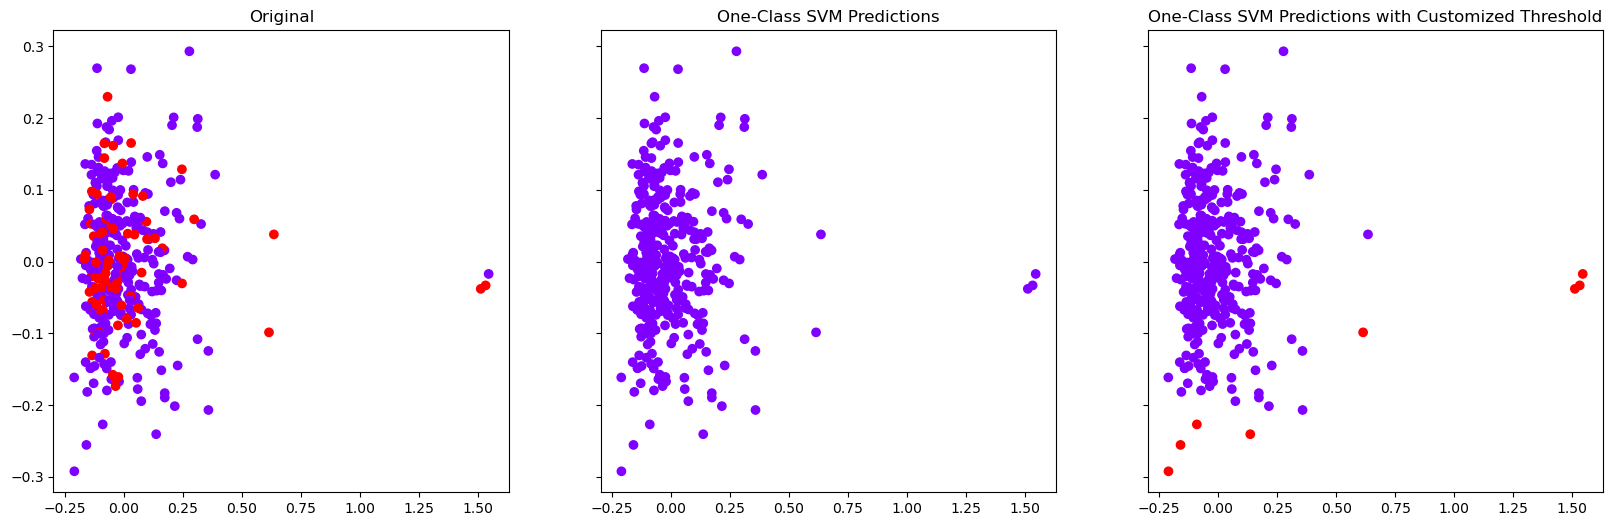

In [444]:
#Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2)= plt.subplots(1,3, sharey=True, figsize=(20,6))

#Ground truth 
ax0.set_title('Original')
ax0.scatter(df['Feature 1'], df['Feature 2'], c=df['Binary Label'], cmap='rainbow')

#One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df['Feature 1'], df['Feature 2'], c=df['one_class_svm_prediction'], cmap='rainbow')

#One-Class SVM Predictions
ax2.set_title('One-Class SVM Predictions with Customized Threshold')
ax2.scatter(df['Feature 1'], df['Feature 2'], c=df['one_class_svm_prediction_customized'], cmap='rainbow')

### Sample: Plotting with generated data

Make sure to take a segment and how the model sees it. What it happening within this layers. Week 11, DATA-645.

https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html

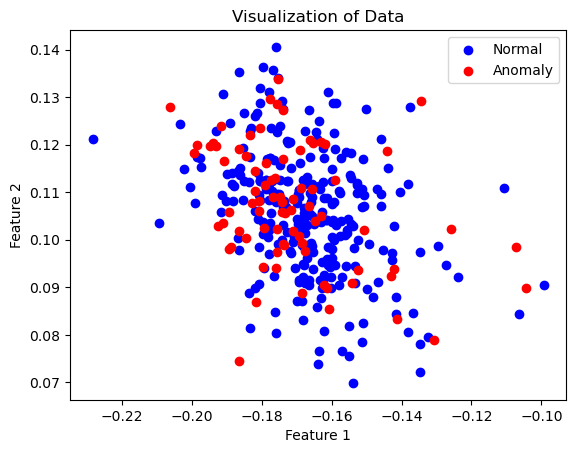

In [427]:
import matplotlib.pyplot as plt

X = dense_test_X
y = test_y
# Plot normal instances (class 0)
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', label='Normal')
# Plot anomalies (class 1)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', label='Anomaly')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Data')
plt.legend()
plt.show()
